In [274]:
import re
import os
import random
import spacy
import ast
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

nlp = spacy.load("en_core_web_sm")

# Data Collection and Visualizations

## Get the Data

The data is downloaded from Stack Exchange Data Explorer (SEDE) using SQL queries. The downloaded data is in the csv form. Here we load the data to work with using Pandas.

In [62]:
data = pd.read_csv('./data/stackoverflow_nlp_posts.csv')
data = data.drop('Id', axis=1) # drop Id column to match assignment specification
data.head()

,QuestionTitle,QuestionBody,Tags,AcceptedAnswer,NumAnswers,QuestionCreationDate,QuestionViewCount,QuestionScore,QuestionClosedDate,AnswerScore
0,Are transformer-based language models overfitt...,<p>I've been working on a sentence transformat...,<machine-learning><nlp><artificial-intelligenc...,NaN,2,2021-05-27 00:52:49,3024,1,NaN,NaN
1,Natural language date/time parser for .NET?,<p>Does anyone know of a .NET date/time parser...,<.net><datetime><nlp>,<p>We developed exactly what you are looking f...,9,2008-08-22 22:45:10,6484,27,2017-04-14 12:11:52,12.0
2,What's a good natural language library to use ...,<p>I'm looking for an existing library to summ...,<language-agnostic><nlp>,NaN,4,2008-08-24 20:57:33,6491,14,2016-01-02 07:47:22,NaN
3,Antlr4 with Python 3 do not accept accented words,<p>I'm trying to use Antlr4 with Python3 but t...,<java><python><nlp><antlr><nltk>,NaN,0,2015-11-22 19:00:14,269,0,NaN,NaN
4,Vista speech recognition in multiple languages,"<p>my primary language is spanish, but I use a...",<windows-vista><nlp><speech-recognition><multi...,"<p>Citation from Vista <a href=""http://blogs.m...",6,2008-08-31 01:08:48,5661,3,NaN,8.0


## Raw Visualizations

These are the visualisations for exploratory reasons prior to preprocessing.

### Distribution of Posted Questions in Time

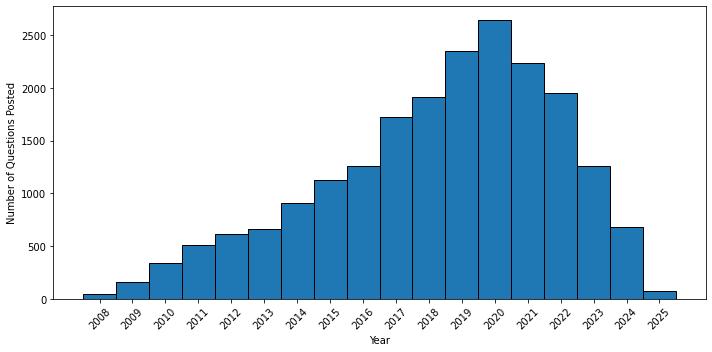

In [63]:
# change QuestionCreationDate to pandas
data['QuestionCreationDate'] = pd.to_datetime(data['QuestionCreationDate'])
# count of data in each year
counts = data['QuestionCreationDate'].dt.to_period('Y').value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 5))
plt.bar(counts.index.year, counts.values, width=1, edgecolor='black')
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xticks(ticks = counts.index.year, rotation=45, fontweight='light')
plt.xlabel("Year")
plt.ylabel("Number of Questions Posted")
plt.tight_layout()
plt.show()

### Distribution of Question Title Lengths

Biggest question title length:  150
Smallest question title length:  12
Mean:  59.266363369533316


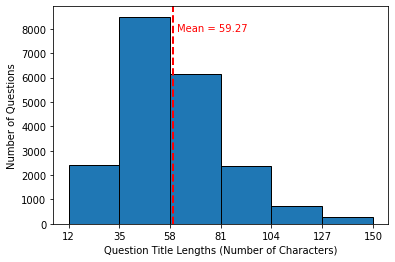

In [64]:
length_of_question_title = data['QuestionTitle'].str.len()
print('Biggest question title length: ', max(length_of_question_title))
print('Smallest question title length: ', min(length_of_question_title))
mean = sum(length_of_question_title)/len(length_of_question_title)
print('Mean: ', mean)
x_ticks = list(range(12,151,int((150-12)/6))) # set the appropriate xticks based on smallest and largest lengths

# plot
plt.hist(length_of_question_title, bins=6, edgecolor='black')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2)
plt.text(mean + 2, plt.ylim()[1] * 0.9, f'Mean = {mean:.2f}',
         color='red', verticalalignment='center')
plt.xlabel('Question Title Lengths (Number of Characters)')
plt.xticks(x_ticks)
plt.ylabel('Number of Questions')
plt.show()

### Distribution of Question Body Lengths

Biggest question body length:  53411
Smallest question body length:  52
Mean:  1534.8391057626454


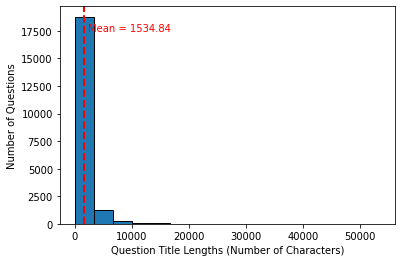

In [65]:
length_of_question_body = data['QuestionBody'].str.len()
print('Biggest question body length: ', max(length_of_question_body))
print('Smallest question body length: ', min(length_of_question_body))
mean = sum(length_of_question_body)/len(length_of_question_body)
print('Mean: ', mean)

# plot
plt.hist(length_of_question_body, bins="sturges", edgecolor='black', )
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2)
plt.text(mean + 800, plt.ylim()[1] * 0.9, f'Mean = {mean:.2f}',
         color='red', verticalalignment='center')
plt.xlabel('Question Title Lengths (Number of Characters)')
plt.ylabel('Number of Questions')
plt.show()


### Distribution of Answer Lengths

Biggest question body length:  29873
Smallest question body length:  40
Mean:  1252.898472385429


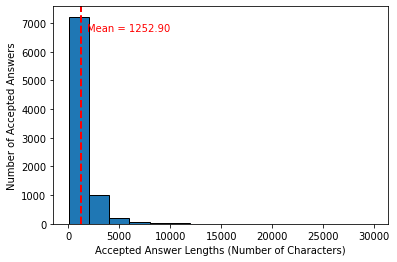

In [66]:
length_of_answers = data[data['AcceptedAnswer'].notna()]['AcceptedAnswer'].str.len()
print('Biggest question body length: ', max(length_of_answers))
print('Smallest question body length: ', min(length_of_answers))
mean = sum(length_of_answers)/len(length_of_answers)
print('Mean: ', mean)

# plot
plt.hist(length_of_answers, bins="sturges", edgecolor='black', )
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2)
plt.text(mean + 600, plt.ylim()[1] * 0.9, f'Mean = {mean:.2f}',
         color='red', verticalalignment='center')
plt.xlabel('Accepted Answer Lengths (Number of Characters)')
plt.ylabel('Number of Accepted Answers')
plt.show()

### Proportions of Answered and Unanswered Questions

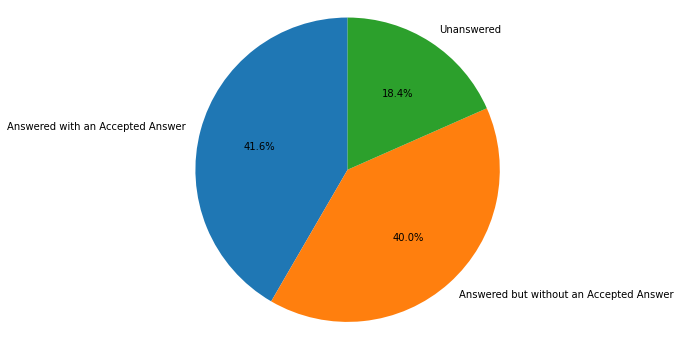

In [67]:
# function to categorise each row
def categorise(row):
    if pd.notna(row['AcceptedAnswer']):
        return 'Answered with an Accepted Answer'
    elif pd.isna(row['AcceptedAnswer']) and (row['NumAnswers'] != 0) :
        return 'Answered but without an Accepted Answer'
    else:
        return 'Unanswered'

# make a Series of categories
categories = data.apply(categorise, axis=1)

# Count occurrences of each category
counts = categories.value_counts()

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Make pie chart circular
plt.show()

# Data Pre-Processing

We will pre-process data into a new data called `pp_data`.

In [68]:
pp_data = data.copy()
pp_data.head()

,QuestionTitle,QuestionBody,Tags,AcceptedAnswer,NumAnswers,QuestionCreationDate,QuestionViewCount,QuestionScore,QuestionClosedDate,AnswerScore
0,Are transformer-based language models overfitt...,<p>I've been working on a sentence transformat...,<machine-learning><nlp><artificial-intelligenc...,NaN,2,2021-05-27 00:52:49,3024,1,NaN,NaN
1,Natural language date/time parser for .NET?,<p>Does anyone know of a .NET date/time parser...,<.net><datetime><nlp>,<p>We developed exactly what you are looking f...,9,2008-08-22 22:45:10,6484,27,2017-04-14 12:11:52,12.0
2,What's a good natural language library to use ...,<p>I'm looking for an existing library to summ...,<language-agnostic><nlp>,NaN,4,2008-08-24 20:57:33,6491,14,2016-01-02 07:47:22,NaN
3,Antlr4 with Python 3 do not accept accented words,<p>I'm trying to use Antlr4 with Python3 but t...,<java><python><nlp><antlr><nltk>,NaN,0,2015-11-22 19:00:14,269,0,NaN,NaN
4,Vista speech recognition in multiple languages,"<p>my primary language is spanish, but I use a...",<windows-vista><nlp><speech-recognition><multi...,"<p>Citation from Vista <a href=""http://blogs.m...",6,2008-08-31 01:08:48,5661,3,NaN,8.0


## Remove Code Snippets

Code snippets include those that are inside the `<code></code>` blocks and those that are inside triple backticks (```).

In [69]:
# define function to remove code snippets per row
def code_parser(row):
    if (pd.isna(row)):
        return row
    # remove codes inside <code></code> blocks
    parser = BeautifulSoup(row, "html.parser")
    for tag in parser.find_all("code"):
        tag.decompose()
    parsed_text = str(parser)

    # remove codes inside triple backticks
    parsed_text = re.sub(r'```.*?```', '', parsed_text, flags=re.DOTALL)
    
    return parsed_text

In [70]:
# apply code_parser to remove code snippets from `QuestionBody` and `AcceptedAnswer`
pp_data['QuestionBodyPreprocessed'] = pp_data['QuestionBody'].apply(code_parser)
pp_data['AcceptedAnswerPreprocessed'] = pp_data['AcceptedAnswer'].apply(code_parser)

## Remove `<blockquote>`

From inspection, blockquotes are sometimes filled with texts that do not convey the actual question. Usually they are put in to give examples. This just adds to the noise.

In [71]:
# define function to remove blockquotes per row
def blockquote_parser(row):
    if (pd.isna(row)):
        return row
    # remove codes inside <code></code> blocks
    parser = BeautifulSoup(row, "html.parser")
    for tag in parser.find_all("blockquote"):
        tag.decompose()
    parsed_text = str(parser)
    
    return parsed_text

In [72]:
# apply blockquote_parser to remove blockquotes from `QuestionBody` and `AcceptedAnswer`
pp_data['QuestionBodyPreprocessed'] = pp_data['QuestionBodyPreprocessed'].apply(blockquote_parser)
pp_data['AcceptedAnswerPreprocessed'] = pp_data['AcceptedAnswerPreprocessed'].apply(blockquote_parser)

## Remove HTML Tags

There are HTML Tags in `QuestionBody` that should be removed as follows

In [73]:
# define function to remove html tags per row
def html_parser(row):
    if pd.isna(row):
        return row
    parser = BeautifulSoup(row, "html.parser")
    parsed_text = parser.get_text()
    return parsed_text



In [74]:
# apply html_parser to remove html tags from `QuestionBody` and `AcceptedAnswer`
pp_data['QuestionBodyPreprocessed'] = pp_data['QuestionBodyPreprocessed'].apply(html_parser)
pp_data['AcceptedAnswerPreprocessed'] = pp_data['AcceptedAnswerPreprocessed'].apply(html_parser)

## Remove Markdown

After inspecting some sample of observations, the only markdown that prevails are bold and italics.

In [75]:
# define function to remove markdowns (bold and italics) per row
def md_parser(row):
    if pd.isna(row):
        return row
    row = re.sub(r'(\*\*|__)(.*?)\1', r'\2', row)
    return row

In [76]:
# apply md_parser to remove markdowns (bold and italics) from `QuestionBody` and `AcceptedAnswer`
pp_data['QuestionBodyPreprocessed'] = pp_data['QuestionBodyPreprocessed'].apply(md_parser)
pp_data['AcceptedAnswerPreprocessed'] = pp_data['AcceptedAnswerPreprocessed'].apply(md_parser)

## Remove Links

Links wiht 'https:\\\\...' or 'http:\\\\...'

In [77]:
# define function to remove links per row
def link_parser(row):
    if pd.isna(row):
        return row
    row = re.sub(r'https?://\S+', '', row)
    return row

In [78]:
# apply link_parser to remove links from `QuestionBody` and `AcceptedAnswer`
pp_data['QuestionBodyPreprocessed'] = pp_data['QuestionBodyPreprocessed'].apply(link_parser)
pp_data['AcceptedAnswerPreprocessed'] = pp_data['AcceptedAnswerPreprocessed'].apply(link_parser)

## Remove Newline Character ("\n") and Normalise Whitespace

In [79]:
# function to remove any leftover newline character and abnormal whitespace 
def clean(row):
    if pd.isna(row):
        return row
    row = row.replace("\n", " ")
    row = row.strip()  # Remove leading/trailing whitespace
    row = re.sub(r"\s+", " ", row)  # Normalize whitespace
    return row

In [80]:
pp_data["QuestionTitlePreprocessed"] = pp_data["QuestionTitle"].apply(clean)
pp_data["QuestionBodyPreprocessed"] = pp_data["QuestionBodyPreprocessed"].apply(clean)
pp_data["AcceptedAnswerPreprocessed"] = pp_data["AcceptedAnswerPreprocessed"].apply(clean)

## Convert the Strings in `Tags` into a List of Tags

e.g convert `"<machine-learning><nlp><stanford-nlp>"` to `['machine-learning', 'nlp', 'stanford-nlp']`

In [81]:
# define function to convert tags into a list
def tag_parser(row):
    tag_list = re.findall(r'<(.*?)>', row)
    return tag_list

In [82]:
# apply tag_parser to convert tags in `Tags`
pp_data['Tags'] = pp_data['Tags'].apply(tag_parser)

## Remove Punctuations, Digits not Contained within a Word, Stop Words, Convert to Lowercase, and Perform Lemmatisation

In [83]:
def spacy_preprocess(row):
    if pd.isna(row):
        return row
    doc = nlp(row)
    tokens = []
    for token in doc:
        # Skip if token is a stop word, punctuation, digit (not inside a word), or space
        if token.is_stop or token.is_punct or token.is_space:
            continue
        if token.like_num and not token.is_alpha:
            continue
        # Keep if it's a word or alphanumeric, not standalone digits or punctuation
        if token.is_alpha or token.text.isalnum():
            tokens.append(token.lemma_.lower())

    return tokens


We apply `spacy_preprocess` on the data as follows. However, as spaCy's `nlp()` takes time to process, we save the result into a file for faster and easier subsequent access. We provide a control (`rerun`) that we can switch (True/False), if we want to  rerun this preprocessing step regardless.

In [183]:
rerun = False
if not os.path.exists("./data/preprocessed_data.csv") or rerun:
    pp_data['QuestionTitlePreprocessed2'] = pp_data['QuestionTitlePreprocessed'].apply(spacy_preprocess)
    pp_data['QuestionBodyPreprocessed2'] = pp_data['QuestionBodyPreprocessed'].apply(spacy_preprocess)
    pp_data['AcceptedAnswerPreprocessed2'] = pp_data['AcceptedAnswerPreprocessed'].apply(spacy_preprocess)
    pp_data.to_csv('./data/preprocessed_data.csv', index=False)
else:
    pp_data = pd.read_csv('./data/preprocessed_data.csv')
    # convert strings into lists except for NAs
    pp_data['Tags'] = pp_data['Tags'].apply(ast.literal_eval)
    pp_data['QuestionTitlePreprocessed2'] = pp_data['QuestionTitlePreprocessed2'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)
    pp_data['QuestionBodyPreprocessed2'] = pp_data['QuestionBodyPreprocessed2'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)
    pp_data['AcceptedAnswerPreprocessed2'] = pp_data['AcceptedAnswerPreprocessed2'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

pp_data.head(3)

,QuestionTitle,QuestionBody,Tags,AcceptedAnswer,NumAnswers,QuestionCreationDate,QuestionViewCount,QuestionScore,QuestionClosedDate,AnswerScore,QuestionBodyPreprocessed,AcceptedAnswerPreprocessed,QuestionTitlePreprocessed,QuestionTitlePreprocessed2,QuestionBodyPreprocessed2,AcceptedAnswerPreprocessed2
0,Are transformer-based language models overfitt...,<p>I've been working on a sentence transformat...,"[machine-learning, nlp, artificial-intelligenc...",NaN,2,2021-05-27 00:52:49,3024,1,NaN,NaN,I've been working on a sentence transformation...,NaN,Are transformer-based language models overfitt...,"[transformer, base, language, model, overfitte...","[work, sentence, transformation, task, involve...",NaN
1,Natural language date/time parser for .NET?,<p>Does anyone know of a .NET date/time parser...,"[.net, datetime, nlp]",<p>We developed exactly what you are looking f...,9,2008-08-22 22:45:10,6484,27,2017-04-14 12:11:52,12.0,Does anyone know of a .NET date/time parser si...,We developed exactly what you are looking for ...,Natural language date/time parser for .NET?,"[natural, language, date, time, parser]","[know, date, time, parser, similar, chronic, r...","[develop, exactly, look, internal, project, th..."
2,What's a good natural language library to use ...,<p>I'm looking for an existing library to summ...,"[language-agnostic, nlp]",NaN,4,2008-08-24 20:57:33,6491,14,2016-01-02 07:47:22,NaN,I'm looking for an existing library to summari...,NaN,What's a good natural language library to use ...,"[good, natural, language, library, use, paraph...","[look, exist, library, summarize, paraphrase, ...",NaN


## Filter Only Answered Questions

In [209]:
# filter only answered questions
pp_data = pp_data[pp_data["NumAnswers"]!=0]
# reset the index and drop the old one
pp_data.reset_index(drop=True, inplace=True)
pp_data

,QuestionTitle,QuestionBody,Tags,AcceptedAnswer,NumAnswers,QuestionCreationDate,QuestionViewCount,QuestionScore,QuestionClosedDate,AnswerScore,QuestionBodyPreprocessed,AcceptedAnswerPreprocessed,QuestionTitlePreprocessed,QuestionTitlePreprocessed2,QuestionBodyPreprocessed2,AcceptedAnswerPreprocessed2,QuestionTitleBodyPreprocessed,QuestionTitleBodyPreprocessed2
0,Are transformer-based language models overfitt...,<p>I've been working on a sentence transformat...,"[machine-learning, nlp, artificial-intelligenc...",NaN,2,2021-05-27 00:52:49,3024,1,NaN,NaN,I've been working on a sentence transformation...,NaN,Are transformer-based language models overfitt...,"[transformer, base, language, model, overfitte...","[work, sentence, transformation, task, involve...",NaN,Are transformer-based language models overfitt...,transformer base language model overfitte para...
1,Natural language date/time parser for .NET?,<p>Does anyone know of a .NET date/time parser...,"[.net, datetime, nlp]",<p>We developed exactly what you are looking f...,9,2008-08-22 22:45:10,6484,27,2017-04-14 12:11:52,12.0,Does anyone know of a .NET date/time parser si...,We developed exactly what you are looking for ...,Natural language date/time parser for .NET?,"[natural, language, date, time, parser]","[know, date, time, parser, similar, chronic, r...","[develop, exactly, look, internal, project, th...",Natural language date/time parser for .NET? Do...,natural language date time parser know date ti...
2,What's a good natural language library to use ...,<p>I'm looking for an existing library to summ...,"[language-agnostic, nlp]",NaN,4,2008-08-24 20:57:33,6491,14,2016-01-02 07:47:22,NaN,I'm looking for an existing library to summari...,NaN,What's a good natural language library to use ...,"[good, natural, language, library, use, paraph...","[look, exist, library, summarize, paraphrase, ...",NaN,What's a good natural language library to use ...,good natural language library use paraphrasing...
3,Vista speech recognition in multiple languages,"<p>my primary language is spanish, but I use a...","[windows-vista, nlp, speech-recognition, multi...","<p>Citation from Vista <a href=""http://blogs.m...",6,2008-08-31 01:08:48,5661,3,NaN,8.0,"my primary language is spanish, but I use all ...",Citation from Vista speech recognition blog:,Vista speech recognition in multiple languages,"[vista, speech, recognition, multiple, language]","[primary, language, spanish, use, software, en...","[citation, vista, speech, recognition, blog]",Vista speech recognition in multiple languages...,vista speech recognition multiple language pri...
4,NLTK named entity recognition in dutch,<p>I am trying to extract named entities from ...,"[python, nlp, nltk, named-entity-recognition]",<p>The <code>conll2002</code> corpus has both ...,1,2012-07-02 11:54:10,5984,8,NaN,7.0,I am trying to extract named entities from dut...,"The corpus has both spanish and dutch text, so...",NLTK named entity recognition in dutch,"[nltk, name, entity, recognition, dutch]","[try, extract, name, entity, dutch, text, nltk...","[corpus, spanish, dutch, text, sure, use, para...",NLTK named entity recognition in dutch. I am t...,nltk name entity recognition dutch try extract...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16679,Label text documents - Supervised Machine Lear...,<p>I'm currently working on a project where I'...,"[nlp, nltk, stanford-nlp, opennlp]",NaN,3,2017-07-16 04:05:42,862,2,NaN,NaN,I'm currently working on a project where I'm t...,NaN,Label text documents - Supervised Machine Lear...,"[label, text, document, supervised, machine, l...","[currently, work, project, take, email, strip,...",NaN,Label text documents - Supervised Machine Lear...,label text document supervised machine learnin...
16680,How to extract numbers (along with comparison ...,"<p>I am working on two NLP projects in Python,...","[python, regex, nlp, nltk, spacy]",<p>I would probably approach this as a chunkin...,

# Data Visualization

## Distribution of Question Body Length

Biggest question body length after preprocessing:  46269
Smallest question body length after preprocessing:  52
Mean:  1423.0733037640853


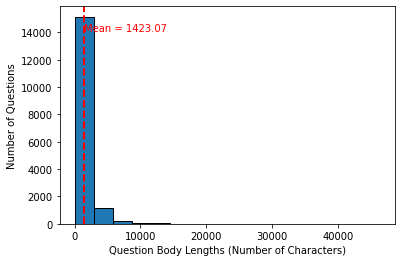

In [210]:
length_of_question_body_pp = pp_data['QuestionBody'].str.len()
print('Biggest question body length after preprocessing: ', max(length_of_question_body_pp))
print('Smallest question body length after preprocessing: ', min(length_of_question_body_pp))
mean = sum(length_of_question_body_pp[pd.notna(length_of_question_body_pp)])/len(length_of_question_body_pp[pd.notna(length_of_question_body_pp)])
print('Mean: ', mean)

# plot
plt.hist(length_of_question_body_pp, bins="sturges", edgecolor='black', )
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2)
plt.text(mean + 50, plt.ylim()[1] * 0.9, f'Mean = {mean:.2f}',
         color='red', verticalalignment='center')
plt.xlabel('Question Body Lengths (Number of Characters)')
plt.ylabel('Number of Questions')
plt.show()

## Word Cloud

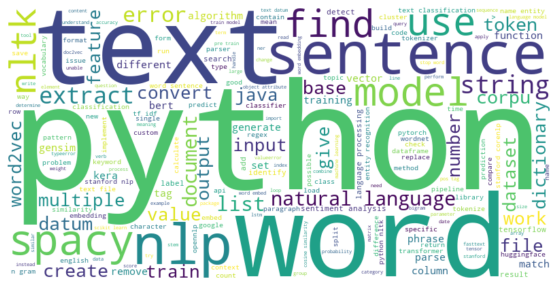

In [211]:
# join all the non-NA titles in the data
text = " ".join(pp_data['QuestionTitlePreprocessed2'].apply(lambda x: " ".join(x)))

# create the word cloud
word_cloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# display the word cloud
plt.figure(figsize=(10,5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()


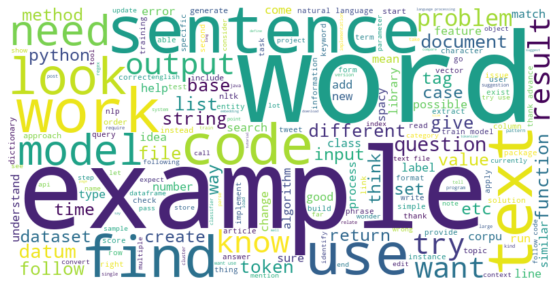

In [212]:
# join all the non-NA titles in the data
text = " ".join(pp_data['QuestionBodyPreprocessed2'].apply(lambda x: " ".join(x)))

# create the word cloud
word_cloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# display the word cloud
plt.figure(figsize=(10,5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Data Categorisation

## BERT Topic

### Embedding

The embedding uses the lightly preprocessed data: code snippet removal, blockquote removal, HTML tags removal, markdown removal, links removal, newline removal, and whitespace normalisation. No lowercasing, lemmatization, and tokenization done to keep the sentences human-readable. This is so that BERT can learn the context.

In [213]:
# Load the 'all-MiniLM-L6-v2' transformer model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

In [216]:
# prepare the docs by combining QuestionTitlePreprocess and QuestionBodyPreProcess

# function to combine QuestionTitle and QuestionBody
def combine_title_body(row):
    if (row["QuestionTitlePreprocessed"][-1] == "?") | (row["QuestionTitlePreprocessed"][-1] == "."):
        separator = " "
    else:
        separator = ". "
    if pd.isna(row["QuestionBodyPreprocessed"]):
        return row["QuestionTitlePreprocessed"]
    else:
        return row["QuestionTitlePreprocessed"] + separator + row["QuestionBodyPreprocessed"]

# combine
pp_data["QuestionTitleBodyPreprocessed"] = pp_data.apply(combine_title_body, axis = 1)

In [217]:
rerun = False # control
if not os.path.exists("./data/embeddings.csv") or rerun:
    # generate embeddings
    embeddings = embedding_model.encode(pp_data["QuestionTitleBodyPreprocessed"], show_progress_bar=True)
    # Convert to DataFrame
    df_embeddings = pd.DataFrame(embeddings)
    # Save
    df_embeddings.to_csv("./data/embeddings.csv", index=False)
else:
    embeddings = pd.read_csv("./data/embeddings.csv").values

Batches:   0%|          | 0/522 [00:00<?, ?it/s]

### Docs

The docs uses the preprocessed2 data which have been processed like that for embedding generation but with additional preprocessing steps of lowercasing, stopwords removal, punctuation removal, lemmatization, and tokenisation. This is so that BERTopic can extract representative words for topics.

In [218]:
# combine QuestionTitlePreprocessed2 and QuestionBodyPreprocessed2
pp_data["QuestionTitleBodyPreprocessed2"] = pp_data["QuestionTitlePreprocessed2"] + pp_data["QuestionBodyPreprocessed2"]
# join the tokens
pp_data["QuestionTitleBodyPreprocessed2"] = pp_data["QuestionTitleBodyPreprocessed2"].apply(lambda x: " ".join(x))

docs = pp_data["QuestionTitleBodyPreprocessed2"]


### Fit Model

In [220]:
# create the model
topic_model = BERTopic()

# Fit the model to the question titles and bodies
topics, probs = topic_model.fit_transform(docs, embeddings=embeddings)

In [ ]:
rerun = False # control
if not os.path.exists("./data/original_topics.csv") or rerun:
    result_original = topic_model.get_topic_info()
    result_original = pd.DataFrame(result_original) # convert to Pandas Dataframe
    result_original.to_csv("./data/original_topics.csv", index=False) # Save
else:
    result_original = pd.read_csv("./data/original_topics.csv")

### Visualizations

In [225]:
topic_model.visualize_hierarchy()

In [226]:
topic_model.visualize_documents(docs, embeddings=embeddings, hide_annotations=True, hide_document_hover=True)

### Categorise Remaining Outliers

In [228]:
# categorise remaining outliers
new_topics = topic_model.reduce_outliers(docs, topics, strategy="embeddings", embeddings=embeddings)

In [234]:
# update the topics
topic_model.update_topics(docs, topics=new_topics)

2025-04-21 14:03:21,671 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [ ]:
rerun = False # control
if not os.path.exists("./data/updated_topics.csv") or rerun:
    result_updated = topic_model.get_topic_info()
    result_updated = pd.DataFrame(result_updated) # convert to Pandas Dataframe
    result_updated.to_csv("./data/updated_topics.csv", index=False) # Save
else:
    result_updated = pd.read_csv("./data/updated_topics.csv")

In [240]:
topic_model.visualize_documents(docs, embeddings=embeddings, hide_annotations=True, hide_document_hover=True)

In [241]:
topic_model.visualize_hierarchy()

## Assigning Topics

In [270]:
# read in manually categorised topics
topic_category = pd.read_csv("./data/topic_category.csv")
topic_category.head(5)

,Topic,Word Representation,CategoryLv3,Category Lv. 2,Category Lv. 1
0,40,"['loss', 'epoch', 'accuracy', 'validation', 't...",Neural Network Model Training,Deep Learning with Neural Networks,Machine Learning and Deep Learning Approaches
1,131,"['predict', 'prediction', 'label', 'class', 'k...",Classification Supervised Machine Learning wit...,Deep Learning with Neural Networks,Machine Learning and Deep Learning Approaches
2,110,"['lstm', 'sequence', 'rnn', 'length', 'input',...",Recurrent Neural Networks (RNNs) for Sequence ...,Deep Learning with Neural Networks,Machine Learning and Deep Learning Approaches
3,35,"['layer', 'embed', 'embedding', 'cnn', 'dimens...",Neural Network Embeddings Layers,Deep Learning with Neural Networks,Machine Learning and Deep Learning Approaches
4,11,"['shape', 'error', 'keras', 'layer', 'tensor',...",Debugging Shape Errors in Neural Networks,Deep Learning with Neural Networks,Machine Learning and Deep Learning Approaches


In [273]:
# get the original data that was processed by the model
final_data = pp_data.copy()
# drop every column except the first 5
final_data = final_data.iloc[:, :5]
# insert topic number
final_data["Topic"] = new_topics
# merge with final_data with result_updated
final_data = pd.merge(final_data, topic_category, on='Topic')
#save
final_data.to_csv("./data/final_data.csv", index=False)
final_data

,QuestionTitle,QuestionBody,Tags,AcceptedAnswer,NumAnswers,Topic,Word Representation,CategoryLv3,Category Lv. 2,Category Lv. 1
0,Are transformer-based language models overfitt...,<p>I've been working on a sentence transformat...,"[machine-learning, nlp, artificial-intelligenc...",NaN,2,46,"['grammar', 'sentence', 'english', 'parser', '...",Grammar Checking and Sentence Parsing Tools fo...,Syntactic and Semantic Analysis in NLP and Com...,Syntactic and Semantic Analysis
1,Natural language date/time parser for .NET?,<p>Does anyone know of a .NET date/time parser...,"[.net, datetime, nlp]",<p>We developed exactly what you are looking f...,9,15,"['date', 'time', 'day', 'sutime', 'temporal', ...",Temporal Expression Recognition and Normalization,Syntactic and Semantic Analysis in NLP and Com...,Syntactic and Semantic Analysis
2,What's a good natural language library to use ...,<p>I'm looking for an existing library to summ...,"[language-agnostic, nlp]",NaN,4,22,"['natural', 'language', 'processing', 'nlp', '...",Natural Language Processing (NLP) Tools and Li...,Syntactic and Semantic Analysis in NLP and Com...,Syntactic and Semantic Analysis
3,Vista speech recognition in multiple languages,"<p>my primary language is spanish, but I use a...","[windows-vista, nlp, speech-recognition, multi...","<p>Citation from Vista <a href=""http://blogs.m...",6,140,"['arabic', 'support', 'language', 'translate',...",Multilingual NLP and Chatbot for Morphological...,Multilingual NLP for Morphologically Rich and ...,Multilingual NLP
4,NLTK named entity recognition in dutch,<p>I am trying to extract named entities from ...,"[python, nlp, nltk, named-entity-recognition]",<p>The <code>conll2002</code> corpus has both ...,1,45,"['chunk', 'tag', 'nltk', 'pos', 'chunker', 'pa...",Shallow Parsing (Chunking) of Phrases Using NLTK,Part-of-Speech Tagging and Shallow Parsing,Syntactic and Semantic Analysis
...,...,...,...,...,...,...,...,...,...,...
16679,Label text documents - Supervised Machine Lear...,<p>I'm currently working on a project where I'...,"[nlp, nltk, stanford-nlp, opennlp]",NaN,3,29,"['classification', 'classifier', 'feature', 'c...",Text Classification Using Supervised Learning,Text Classification,Classification and Sentiment
16680,How to extract numbers (along with comparison ...,"<p>I am working on two NLP projects in Python,...","[python, regex, nlp, nltk, spacy]",<p>I would probably approach this as a chunkin...,2,42,"['number', 'numeric', 'digit', 'convert', 'reg...",Extracting and Converting Numeric Values from ...,"Text Cleaning, Pattern Matching, and Data Prep...",Preprocessing
16681,Possible to balance unidic vs. unidic-neologd?,"<p>With the sentence ""場所は多少わかりづらいんですけど、感じのいいとこ...","[nlp, mecab]","<p>Neologd merges with unidic (or ipadic), whi...",1,38,"['name', 'person', 'entity', 'organization', '...",Named Entity Recognition (NER) for Identifying...,Information Extraction and Named Entity Recogn...,Information Extraction
16682,Bad Input Shape Sklearn Error After HashingVec...,<p>I have 204567 words of which 21010 are uniq...,"[python-3.x, machine-learning, scikit-learn, n...",<p>I changed my code as follows and now its wo...,2,18,"['test', 'accuracy', 'classification', 'precis...",Metrics for Evaluating Classification Models U...,Text Classification,Classification and Sentiment


# Sample

In [280]:
random.seed(25)  # replicable
num = random.randint(1, 16684)
print("Question Title: \n", final_data.iloc[num,0])
print("Question Body: \n", final_data.iloc[num,1])
print("Category Lv.3: ", final_data.iloc[num,7])
print("Category Lv.2: ", final_data.iloc[num,8])
print("Category Lv.1: ", final_data.iloc[num,9])

Question Title: 
 scikit-learn "Working with Text Data Tutorial" ignores my target categories
Question Body: 
 <p>I am working on ML algorithms and checked out: <a href="http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html" rel="nofollow">Scikit-Learn Working with Text Tutorial</a></p>

<p>Now I tried using my own training data set with 1 feature = message, and 5 categories rating from -2 (negative) to 2 (positive).</p>

<p>Then I do the same as stated in the tutorial, but it will always return a maximum of 4 target_categories and not 5!</p>

<pre><code>target_categories = ['-2', '-1', '0', '1','2']

print(metrics.classification_report(train_data.Category, predicted,target_names=target_categories))
</code></pre>

<p>I will only get <code>predicted_proba</code> for -2,-1,0,1. for example: <code>[0.2 0.2 0.4 0.4]</code></p>

<p>How come Scikit ist giving me only a 4x1 Vector and not 5x1? Why does the last value in my <code>target_categories</code> get omitte

In [282]:
random.seed(200)  # replicable
num = random.randint(1, 16684)
print("Question Title: \n", final_data.iloc[num,0])
print("Question Body: \n", final_data.iloc[num,1])
print("Category Lv.3: ", final_data.iloc[num,7])
print("Category Lv.2: ", final_data.iloc[num,8])
print("Category Lv.1: ", final_data.iloc[num,9])

Question Title: 
 Convert multiple rows of text into a Single row using Pandas
Question Body: 
 <p>I have a dataframe like as shown below</p>
<pre><code>df = pd.DataFrame({'text': [&quot;Hi how are you&quot;,&quot;I am fine&quot;,&quot;I love you&quot;,&quot;I hate you&quot;]})
</code></pre>
<p>I would like to convert all these individual rows into a single row</p>
<p>I tried the below but it is incorrect and doesn't work</p>
<pre><code>df['text'].apply(' '.join).reset_index()
</code></pre>
<p>I expect my output to be like as shown below</p>
<p><a href="https://i.sstatic.net/ChSOa.png" rel="nofollow noreferrer"><img src="https://i.sstatic.net/ChSOa.png" alt="enter image description here" /></a></p>
<p>How can I do this?</p>

Category Lv.3:  Data Manipulation and Transformation Using Pandas DataFrames
Category Lv.2:  Text Processing and Data Manipulation in DataFrames
Category Lv.1:  Preprocessing


In [284]:
random.seed(250)  # replicable
num = random.randint(1, 16684)
print("Question Title: \n", final_data.iloc[num,0])
print("Question Body: \n", final_data.iloc[num,1])
print("Category Lv.3: ", final_data.iloc[num,7])
print("Category Lv.2: ", final_data.iloc[num,8])
print("Category Lv.1: ", final_data.iloc[num,9])

Question Title: 
 How can I implement in python spacy so the program doesn't match the word if there is any other word that we choose is in the sentence?
Question Body: 
 <p>So i want the program to match with the word &quot;ptu&quot;, which is easy but lets say I want it to not match if the senetence contains &quot;ptu switch&quot;. how can i implement that?</p>
<pre><code>import spacy

nlp = spacy.load(&quot;en_core_web_sm&quot;)
matcher = spacy.matcher.Matcher(nlp.vocab)

# Define the pattern to match &quot;PTU switch&quot;
pattern1 = [{'LOWER': 'ptu'}, {'LOWER': 'switch', 'IS_STOP': True}]

# Add the pattern to the matcher
matcher.add(&quot;PTU_SWITCH&quot;, [pattern1])

# Process the text and check for matches
doc = nlp(&quot;ptu switch was replaced&quot;)
matches = matcher(doc)

# Print the result
if matches:
    for match_id, start, end in matches:
        string_id = nlp.vocab.strings[match_id]  # Get string representation
        span = doc[start:end]
        print(str(span))
